In [1]:
!find "/kaggle/input/fgvc-aircraft-train-val-test/aircraft_dataset" -type f | wc -l

10000


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from IPython.display import FileLink

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
dataset_path = "/kaggle/input/fgvc-aircraft-train-val-test/aircraft_dataset"
batch_size = 16

# Image transformation for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Normalize using mean and std values from ImageNet (dataset on which the pretrained weights were trained)
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

train_path = os.path.join(dataset_path, f"train")
val_path = os.path.join(dataset_path, f"val")
test_path = os.path.join(dataset_path, f"test")

train_ds = ImageFolder(root=train_path, transform=transform)
val_ds = ImageFolder(root=val_path, transform=transform)
test_ds = ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

num_classes = len(train_ds.classes)
print(num_classes)

print(len(train_ds), len(val_ds), len(test_ds))

70
8000 1000 1000


# resnet-50

In [5]:
save_dir = "resnet-50"

from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

print(model.__class__.__name__)

# Model parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"model parameters: {num_params}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s]


ResNet
model parameters: 23651462



Epoch 1/25
Train Loss: 3.4445, Train Acc: 0.1919
Val Loss: 2.2518, Val Acc: 0.4750
validation loss improved, saving model
validation accuracy improved, saving model

Epoch 2/25
Train Loss: 1.5554, Train Acc: 0.6454
Val Loss: 0.8795, Val Acc: 0.7860
validation loss improved, saving model
validation accuracy improved, saving model

Epoch 3/25
Train Loss: 0.6559, Train Acc: 0.8611
Val Loss: 0.5320, Val Acc: 0.8700
validation loss improved, saving model
validation accuracy improved, saving model

Epoch 4/25
Train Loss: 0.3287, Train Acc: 0.9377
Val Loss: 0.4534, Val Acc: 0.8790
validation loss improved, saving model
validation accuracy improved, saving model

Epoch 5/25
Train Loss: 0.1840, Train Acc: 0.9683
Val Loss: 0.4057, Val Acc: 0.8990
validation loss improved, saving model
validation accuracy improved, saving model

Epoch 6/25
Train Loss: 0.0959, Train Acc: 0.9869
Val Loss: 0.3714, Val Acc: 0.9070
validation loss improved, saving model
validation accuracy improved, saving model

Epo

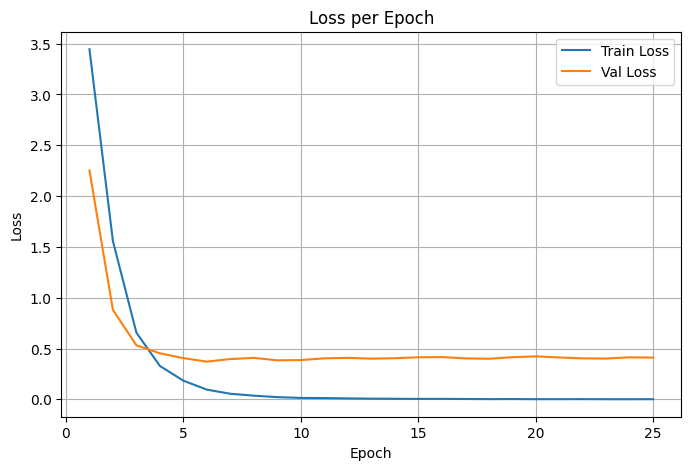

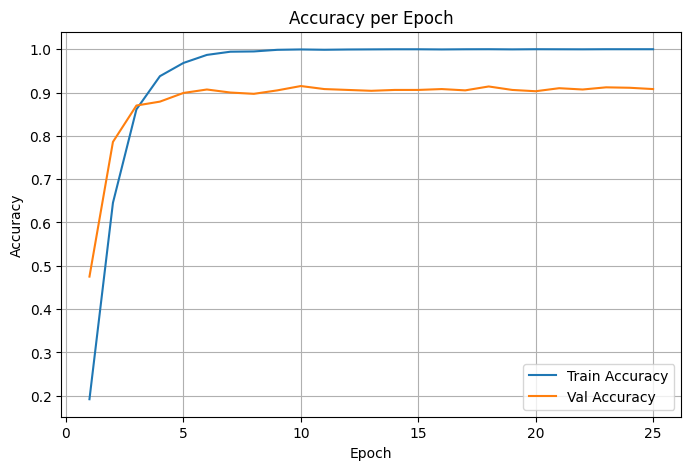

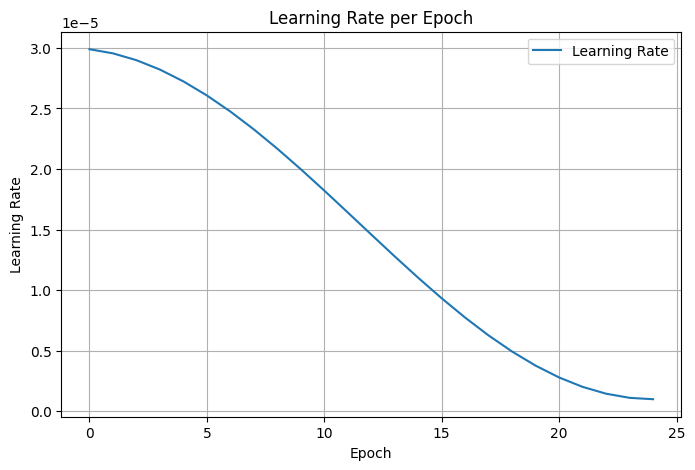

In [6]:
# num_epochs and lr
num_epochs = 25
learning_rate = 3e-5

# loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs, eta_min=1e-6
)


# Training loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss, best_val_accuracy = 3.0, 0.0
lrs = []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"\nEpoch {epoch+1}/{num_epochs}\n"
        f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}\n"
        f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    # Step the scheduler
    scheduler.step()

    # Log current lr
    current_lr = optimizer.param_groups[0]["lr"]
    lrs.append(current_lr)

    # Save model weights per epoch
    os.makedirs(f"{save_dir}/models", exist_ok=True)
    torch.save(model.state_dict(), f"{save_dir}/models/epoch_{epoch+1}.pth")

    # Save the best performing model (loss)
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), f"{save_dir}/models/min_validation_loss.pth")
        print("validation loss improved, saving model")
    # Save the best performing model (accuracy)
    if epoch_val_acc > best_val_accuracy:
        best_val_accuracy = epoch_val_acc
        torch.save(model.state_dict(), f"{save_dir}/models/max_validation_acc.pth")
        print("validation accuracy improved, saving model")


epochs = range(1, num_epochs + 1)

# Plotting loss values
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)
plt.savefig(f"{save_dir}/losses.png")

# Plotting accuracy values
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.savefig(f"{save_dir}/accuracies.png")

# Plotting lr values
plt.figure(figsize=(8, 5))
plt.plot(lrs, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate per Epoch')
plt.legend()
plt.grid(True)
plt.savefig(f"{save_dir}/learning_rate.png")


In [7]:
# Evaluation
model.load_state_dict(torch.load(f"{save_dir}/models/max_validation_acc.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = (all_preds == all_labels).sum() / len(all_labels)
print(f"Test Accuracy: {100 * accuracy:.2f}%")

report = classification_report(all_labels, all_preds, target_names=test_ds.classes)

with open(f"{save_dir}/metrics_max_acc.txt", "w") as f:
    f.write(f"Test Accuracy: {100 * accuracy:.2f}%\n\n")
    f.write("Classification Report:\n")
    f.write(report)


model.load_state_dict(torch.load(f"{save_dir}/models/min_validation_loss.pth"))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = (all_preds == all_labels).sum() / len(all_labels)
print(f"Test Accuracy: {100 * accuracy:.2f}%")

report = classification_report(all_labels, all_preds, target_names=test_ds.classes)

with open(f"{save_dir}/metrics_min_loss.txt", "w") as f:
    f.write(f"Test Accuracy: {100 * accuracy:.2f}%\n\n")
    f.write("Classification Report:\n")
    f.write(report)


model.load_state_dict(torch.load(f"{save_dir}/models/epoch_{num_epochs}.pth"))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = (all_preds == all_labels).sum() / len(all_labels)
print(f"Test Accuracy: {100 * accuracy:.2f}%")

report = classification_report(all_labels, all_preds, target_names=test_ds.classes)

with open(f"{save_dir}/metrics_last_epoch.txt", "w") as f:
    f.write(f"Test Accuracy: {100 * accuracy:.2f}%\n\n")
    f.write("Classification Report:\n")
    f.write(report)


Test Accuracy: 91.60%
Test Accuracy: 89.80%
Test Accuracy: 91.50%


In [8]:
torch.cuda.empty_cache()

In [9]:
!zip {save_dir}.zip {save_dir}/models/max_validation_acc.pth \
                   {save_dir}/models/min_validation_loss.pth \
                   {save_dir}/models/epoch_{num_epochs}.pth \
                   {save_dir}/accuracies.png \
                   {save_dir}/losses.png \
                   {save_dir}/learning_rate.png \
                   {save_dir}/metrics_max_acc.txt \
                   {save_dir}/metrics_min_loss.txt \
                   {save_dir}/metrics_last_epoch.txt

FileLink(f"{save_dir}.zip")

  adding: resnet-50/models/max_validation_acc.pth (deflated 7%)
  adding: resnet-50/models/min_validation_loss.pth (deflated 7%)
  adding: resnet-50/models/epoch_25.pth (deflated 7%)
  adding: resnet-50/accuracies.png (deflated 11%)
  adding: resnet-50/losses.png (deflated 10%)
  adding: resnet-50/learning_rate.png (deflated 10%)
  adding: resnet-50/metrics_max_acc.txt (deflated 82%)
  adding: resnet-50/metrics_min_loss.txt (deflated 82%)
  adding: resnet-50/metrics_last_epoch.txt (deflated 82%)


/kaggle/working/resnet-50.zip

# swin-tiny

In [10]:
save_dir = "swin-tiny"

import timm

model = timm.create_model(
    "swin_tiny_patch4_window7_224",
    pretrained=True,
    num_classes=num_classes
)
model = model.to(device)

print(model.__class__.__name__)

# Model parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"model parameters: {num_params}")

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

SwinTransformer
model parameters: 27573184



Epoch 1/25
Train Loss: 2.3049, Train Acc: 0.4442
Val Loss: 0.9309, Val Acc: 0.7210
validation loss improved, saving model
validation accuracy improved, saving model

Epoch 2/25
Train Loss: 0.6209, Train Acc: 0.8511
Val Loss: 0.4959, Val Acc: 0.8630
validation loss improved, saving model
validation accuracy improved, saving model

Epoch 3/25
Train Loss: 0.2873, Train Acc: 0.9391
Val Loss: 0.3645, Val Acc: 0.8960
validation loss improved, saving model
validation accuracy improved, saving model

Epoch 4/25
Train Loss: 0.1573, Train Acc: 0.9722
Val Loss: 0.3714, Val Acc: 0.8960

Epoch 5/25
Train Loss: 0.1089, Train Acc: 0.9822
Val Loss: 0.3490, Val Acc: 0.9000
validation loss improved, saving model
validation accuracy improved, saving model

Epoch 6/25
Train Loss: 0.0809, Train Acc: 0.9886
Val Loss: 0.3198, Val Acc: 0.9070
validation loss improved, saving model
validation accuracy improved, saving model

Epoch 7/25
Train Loss: 0.0680, Train Acc: 0.9898
Val Loss: 0.3358, Val Acc: 0.9100
va

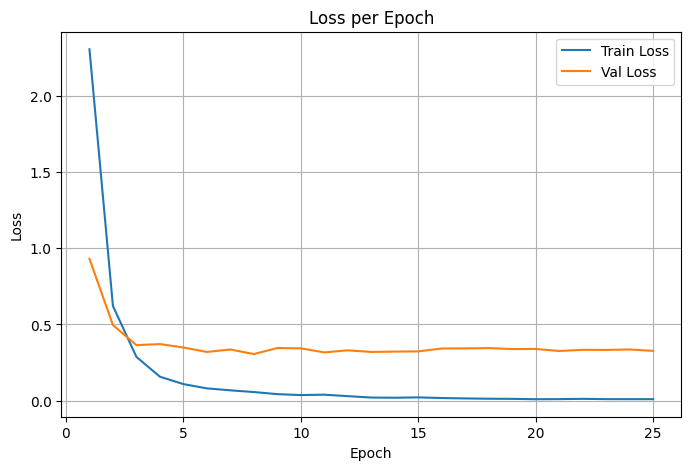

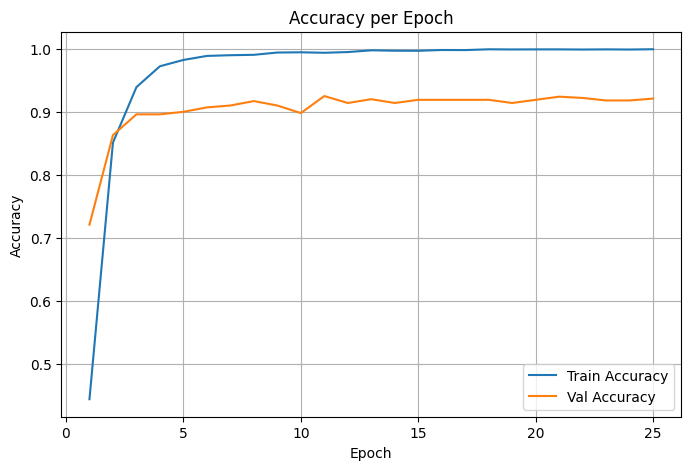

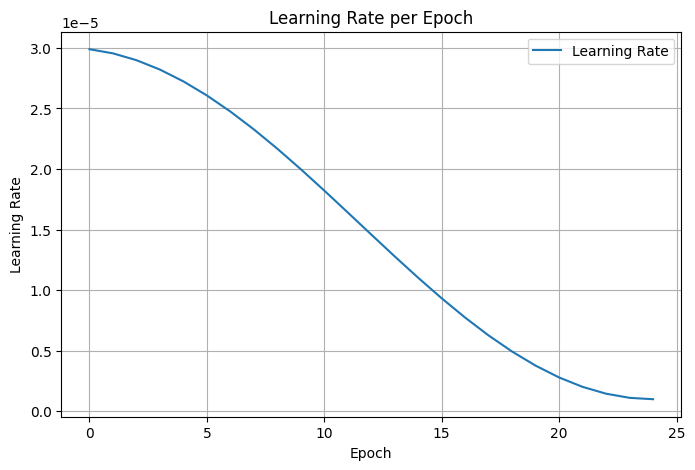

In [11]:
# num_epochs and lr
num_epochs = 25
learning_rate = 3e-5

# loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs, eta_min=1e-6
)


# Training loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss, best_val_accuracy = 3.0, 0.0
lrs = []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"\nEpoch {epoch+1}/{num_epochs}\n"
        f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}\n"
        f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    # Step the scheduler
    scheduler.step()

    # Log current lr
    current_lr = optimizer.param_groups[0]["lr"]
    lrs.append(current_lr)

    # Save model weights per epoch
    os.makedirs(f"{save_dir}/models", exist_ok=True)
    torch.save(model.state_dict(), f"{save_dir}/models/epoch_{epoch+1}.pth")

    # Save the best performing model (loss)
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), f"{save_dir}/models/min_validation_loss.pth")
        print("validation loss improved, saving model")
    # Save the best performing model (accuracy)
    if epoch_val_acc > best_val_accuracy:
        best_val_accuracy = epoch_val_acc
        torch.save(model.state_dict(), f"{save_dir}/models/max_validation_acc.pth")
        print("validation accuracy improved, saving model")


epochs = range(1, num_epochs + 1)

# Plotting loss values
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)
plt.savefig(f"{save_dir}/losses.png")

# Plotting accuracy values
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.savefig(f"{save_dir}/accuracies.png")

# Plotting lr values
plt.figure(figsize=(8, 5))
plt.plot(lrs, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate per Epoch')
plt.legend()
plt.grid(True)
plt.savefig(f"{save_dir}/learning_rate.png")


In [12]:
# Evaluation
model.load_state_dict(torch.load(f"{save_dir}/models/max_validation_acc.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = (all_preds == all_labels).sum() / len(all_labels)
print(f"Test Accuracy: {100 * accuracy:.2f}%")

report = classification_report(all_labels, all_preds, target_names=test_ds.classes)

with open(f"{save_dir}/metrics_max_acc.txt", "w") as f:
    f.write(f"Test Accuracy: {100 * accuracy:.2f}%\n\n")
    f.write("Classification Report:\n")
    f.write(report)


model.load_state_dict(torch.load(f"{save_dir}/models/min_validation_loss.pth"))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = (all_preds == all_labels).sum() / len(all_labels)
print(f"Test Accuracy: {100 * accuracy:.2f}%")

report = classification_report(all_labels, all_preds, target_names=test_ds.classes)

with open(f"{save_dir}/metrics_min_loss.txt", "w") as f:
    f.write(f"Test Accuracy: {100 * accuracy:.2f}%\n\n")
    f.write("Classification Report:\n")
    f.write(report)


model.load_state_dict(torch.load(f"{save_dir}/models/epoch_{num_epochs}.pth"))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = (all_preds == all_labels).sum() / len(all_labels)
print(f"Test Accuracy: {100 * accuracy:.2f}%")

report = classification_report(all_labels, all_preds, target_names=test_ds.classes)

with open(f"{save_dir}/metrics_last_epoch.txt", "w") as f:
    f.write(f"Test Accuracy: {100 * accuracy:.2f}%\n\n")
    f.write("Classification Report:\n")
    f.write(report)


Test Accuracy: 92.20%
Test Accuracy: 91.90%
Test Accuracy: 93.00%


In [13]:
torch.cuda.empty_cache()

In [14]:
!zip {save_dir}.zip {save_dir}/models/max_validation_acc.pth \
                   {save_dir}/models/min_validation_loss.pth \
                   {save_dir}/models/epoch_{num_epochs}.pth \
                   {save_dir}/accuracies.png \
                   {save_dir}/losses.png \
                   {save_dir}/learning_rate.png \
                   {save_dir}/metrics_max_acc.txt \
                   {save_dir}/metrics_min_loss.txt \
                   {save_dir}/metrics_last_epoch.txt

FileLink(f"{save_dir}.zip")

  adding: swin-tiny/models/max_validation_acc.pth (deflated 7%)
  adding: swin-tiny/models/min_validation_loss.pth (deflated 7%)
  adding: swin-tiny/models/epoch_25.pth (deflated 7%)
  adding: swin-tiny/accuracies.png (deflated 10%)
  adding: swin-tiny/losses.png (deflated 10%)
  adding: swin-tiny/learning_rate.png (deflated 10%)
  adding: swin-tiny/metrics_max_acc.txt (deflated 82%)
  adding: swin-tiny/metrics_min_loss.txt (deflated 82%)
  adding: swin-tiny/metrics_last_epoch.txt (deflated 82%)


/kaggle/working/swin-tiny.zip